In [1]:
# Cargar los tokens

In [1]:
!find "../datasets/maestro_encoded/" -name "*.txt" > maestro_encoded_paths.txt

In [2]:
with open('maestro_encoded_paths.txt') as f:
    paths = list(map(lambda p: p.strip(), f.readlines()))

In [3]:
paths

['../datasets/maestro_encoded/maestro-v2.0.0---2015---MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_08_R1_2015_wav--4.txt',
 '../datasets/maestro_encoded/maestro-v2.0.0---2013---ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_12_R2_2013_wav--3.txt',
 '../datasets/maestro_encoded/maestro-v2.0.0---2004---MIDI-Unprocessed_XP_04_R1_2004_06_ORIG_MID--AUDIO_04_R1_2004_08_Track08_wav.txt',
 '../datasets/maestro_encoded/maestro-v2.0.0---2015---MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_08_R2_2015_wav--2.txt',
 '../datasets/maestro_encoded/maestro-v2.0.0---2014---MIDI-UNPROCESSED_04-08-12_R3_2014_MID--AUDIO_12_R3_2014_wav--1.txt',
 '../datasets/maestro_encoded/maestro-v2.0.0---2006---MIDI-Unprocessed_16_R2_2006_01_ORIG_MID--AUDIO_16_R2_2006_02_Track02_wav.txt',
 '../datasets/maestro_encoded/maestro-v2.0.0---2014---MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--5.txt',
 '../datasets/maestro_encoded/maestro-v2.0.0---2006---MIDI-Unprocessed_07_R1_2006_01-04_ORIG_MID--AUDIO_07_R1_200

In [4]:
def read_file(path):
    with open(path) as f:
        tokens = f.readline().split(',')
    return tokens

# read_file(paths[0])

In [5]:
vocabulary = read_file("vocabulary.txt")

In [6]:
CONTEXT_SIZE = 50


def build_ngrams(train_paths, context_size=CONTEXT_SIZE, stride=10):
    all_ngrams = []

    for path in train_paths:
        
        song = read_file(path)  # sequence of tokens

        ngrams = [([song[j] for j in range(i, i + context_size)], song[i + context_size])
                  for i in range(0, len(song) - context_size, stride)]

        all_ngrams.extend(ngrams)
    
    return all_ngrams

In [7]:
ngrams = build_ngrams(paths[:int(len(paths) / 10)])

In [8]:
import json

In [9]:
with open("vocabulary.json", "w") as f:
    json.dump({token: index for index, token in enumerate(vocabulary)}, f)

In [10]:
with open("vocabulary.json") as f:
    vocabulary_dict = json.load(f)

In [11]:
list(vocabulary_dict.keys())[0]

'TIMESHIFT<855>'

In [12]:
from transformers import GPT2Model, GPT2LMHeadModel
import torch

In [13]:
model = GPT2Model.from_pretrained('gpt2')
model

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0): Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (c_fc): Conv1D

In [14]:
from functools import reduce
sum(list(reduce(lambda x, y: x*y, list(p.shape)) for p in model.parameters()))

124439808

In [15]:
model.num_parameters()

124439808

GPT2 de hugging face (GPT-2 small) tiene:
- vocabulario de tamaño 50257.
- embedding de tamaño 768.
- positional embedding de tamaño 1024.
- 12 bloques de tamaño 768
- 124.439.808 parámetros (Como el doble que una AlexNet)

Con tan solo evaluar un input en este modelo llena la ram (~8gb).

Buscaremos implementar una red mucho más pequeña para entrenarla con música.

In [16]:
# inputs = torch.ones((1, 5, 5258), dtype=torch.long)
# model.wte(inputs).shape

In [17]:
# embedding = nn.Embedding(10, 3)
# for p in model.wte.parameters():
#     print(p.shape)

In [18]:
# seq1 = read_file(paths[0])
# len(seq1)

In [19]:
# tokenized = [vocabulary_dict[token] for token in seq1]

In [20]:
model.get_input_embeddings()

Embedding(50257, 768)

In [21]:
# inputs = torch.tensor([tokenized[:769]], dtype=torch.long)
# outputs = model(inputs)

# last_hidden_states = outputs[0]  #

In [22]:
# Output and hiddne states of each head
# len(outputs), len(outputs[1])

In [23]:
# outputs[0].shape

In [24]:
# Definir el modelo con hugging face

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available(), device

(True, device(type='cuda'))

In [26]:
!echo $CUDA_VISIBLE_DEVICES

1


In [27]:
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel

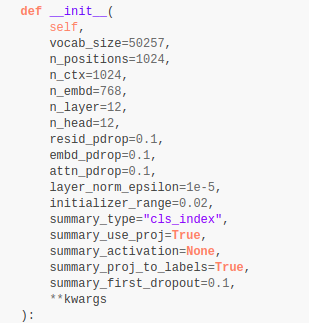

In [28]:
len(vocabulary)

912

In [29]:
# configuracion
params = {
    'vocab_size': len(vocabulary),  # 912
    'n_positions': 1024,  # default
    'n_ctx': 50,
    'n_embd': 8, # default: 768 in GPT-2 Small
                 # (Reducir este parámetro no mejora tanto el
                 # rendimiento segun https://medium.com/huggingface/distilbert-8cf3380435b5)
    'n_layer': 5, # default: 12 in GPT-2 Small
    'n_head': 4,  # default: 12 (n_embd % n_head must be 0)
}
config = GPT2Config(**params)

In [30]:
model = GPT2LMHeadModel(config)

In [31]:
model.num_parameters()

19864

In [32]:
CONTEXT_SIZE = 50

def build_ngrams(train_paths, context_size=CONTEXT_SIZE, stride=10):
    all_ngrams = []

    for path in train_paths:
        
        song = read_file(path)  # sequence of tokens
        
        song = [vocabulary_dict[token] for token in song]

        ngrams = [([song[j] for j in range(i, i + context_size)], song[i + context_size])
                  for i in range(0, len(song) - context_size, stride)]

        all_ngrams.extend(ngrams)
    
    return all_ngrams

In [33]:
ngrams = build_ngrams(paths[:int(len(paths) / 10)])

In [34]:
from torch.utils.data.dataset import Dataset

In [35]:
class MyDataset(Dataset):
    
    def __init__(self, ngrams):
        self.ngrams = ngrams
    
    def __len__(self):
        return len(self.ngrams)
    
    def __getitem__(self, index):
        X, y = self.ngrams[index]
        data = {}
        data["input_ids"] = torch.LongTensor(X)
        data["labels"] = torch.LongTensor(X)
        return data

In [36]:
dataset = MyDataset(ngrams)

In [37]:
ngrams = build_ngrams(paths[:int(len(paths) / 10)], stride=1)
len(ngrams)

2983759

In [38]:
dataset = MyDataset(ngrams)
len(dataset)

2983759

In [39]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./ouputs/gpt2_9_5layers",
    logging_dir="./logs/gpt2_9_5layers",
    overwrite_output_dir=True,
    num_train_epochs=200,
    per_gpu_train_batch_size=4096,
    learning_rate=1e-2,  # default 5e-5
#     save_steps=10,
    logging_steps=100,
#     save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
#     data_collator=data_collator,
    train_dataset=dataset,
    prediction_loss_only=True,
)

In [40]:
trainer.train()

Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.


/home/gschuit/.pyenv/versions/3.6.8/envs/huggingface/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


KeyboardInterrupt: 

In [ ]:
output = model(**dataset[2])

In [ ]:
output[1].shape

# Generation

In [43]:
seq = torch.LongTensor([[vocabulary_dict[token] for token in read_file(paths[0])][:3]])
seq

tensor([[392, 568, 577]])

In [44]:
model.to('cpu')

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(912, 8)
    (wpe): Embedding(1024, 8)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((8,), 

In [45]:
generated = model.generate(seq, max_length=50, repetition_penalty=1)
generated

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


tensor([[392, 568, 577, 263, 490, 263, 490, 263, 199, 519, 263, 490, 263, 490,
         263, 396, 354, 263, 490, 263, 490, 263, 396, 116, 263,  67, 263, 396,
         116, 263, 490, 263, 665, 488, 263,  67, 263, 396, 488, 263,  67, 263,
         396, 322, 263,  67, 263, 396, 263, 396]])

In [46]:
decoder = {index: token for token, index in vocabulary_dict.items()}

In [47]:
[decoder[index.item()] for index in list(generated[0])]

['TIMESHIFT<46>',
 'NOTE-ON<54>',
 'SET-VELOCITY<84>',
 'TIMESHIFT<1>',
 'NOTE-OFF<55>',
 'TIMESHIFT<1>',
 'NOTE-OFF<55>',
 'TIMESHIFT<1>',
 'NOTE-ON<50>',
 'SET-VELOCITY<65>',
 'TIMESHIFT<1>',
 'NOTE-OFF<55>',
 'TIMESHIFT<1>',
 'NOTE-OFF<55>',
 'TIMESHIFT<1>',
 'NOTE-ON<57>',
 'SET-VELOCITY<74>',
 'TIMESHIFT<1>',
 'NOTE-OFF<55>',
 'TIMESHIFT<1>',
 'NOTE-OFF<55>',
 'TIMESHIFT<1>',
 'NOTE-ON<57>',
 'SET-VELOCITY<66>',
 'TIMESHIFT<1>',
 'NOTE-OFF<57>',
 'TIMESHIFT<1>',
 'NOTE-ON<57>',
 'SET-VELOCITY<66>',
 'TIMESHIFT<1>',
 'NOTE-OFF<55>',
 'TIMESHIFT<1>',
 'NOTE-ON<55>',
 'SET-VELOCITY<59>',
 'TIMESHIFT<1>',
 'NOTE-OFF<57>',
 'TIMESHIFT<1>',
 'NOTE-ON<57>',
 'SET-VELOCITY<59>',
 'TIMESHIFT<1>',
 'NOTE-OFF<57>',
 'TIMESHIFT<1>',
 'NOTE-ON<57>',
 'SET-VELOCITY<62>',
 'TIMESHIFT<1>',
 'NOTE-OFF<57>',
 'TIMESHIFT<1>',
 'NOTE-ON<57>',
 'TIMESHIFT<1>',
 'NOTE-ON<57>']

In [48]:
big_generated = [vocabulary_dict[token] for token in read_file(paths[3])][:50]
for i in range(100):
    generated = model.generate(torch.LongTensor([big_generated[:20]]), max_length=50,repetition_penalty=1)
    generated = [index.item() for index in list(generated[0])]
#     brea
    big_generated.extend(generated[20:])
    print(i)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0
1
2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


3
4
5


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


6
7
8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


9
10
11


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


12
13
14


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


15
16
17


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


18
19


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


20
21


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


22
23


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


24
25


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


26
27
28


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


29
30
31


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


32
33
34


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


35
36
37


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


38
39
40


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


41
42
43


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


44
45


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


46
47
48


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


49
50
51


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


52
53
54


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


55
56
57


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


58
59
60


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


61
62
63


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


64
65
66


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


67
68
69


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


70
71
72


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


73
74
75


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


76
77
78


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


79
80
81


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


82
83
84


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


85
86
87


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


88
89
90


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


91
92


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


93
94
95


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


96
97
98
99


In [49]:
big_generated

[148,
 210,
 763,
 263,
 562,
 488,
 735,
 653,
 46,
 150,
 329,
 385,
 58,
 723,
 562,
 488,
 263,
 808,
 860,
 259,
 329,
 796,
 590,
 150,
 735,
 385,
 255,
 562,
 357,
 616,
 329,
 796,
 263,
 199,
 389,
 263,
 90,
 56,
 150,
 329,
 727,
 258,
 398,
 773,
 263,
 378,
 258,
 342,
 263,
 808,
 263,
 231,
 263,
 796,
 263,
 796,
 263,
 385,
 488,
 263,
 342,
 263,
 342,
 263,
 508,
 263,
 385,
 365,
 263,
 796,
 263,
 385,
 488,
 263,
 796,
 263,
 385,
 488,
 263,
 385,
 263,
 490,
 263,
 150,
 263,
 562,
 389,
 263,
 150,
 263,
 150,
 263,
 150,
 263,
 397,
 539,
 263,
 877,
 263,
 397,
 238,
 263,
 231,
 263,
 877,
 263,
 173,
 488,
 263,
 877,
 263,
 67,
 263,
 67,
 263,
 385,
 22,
 263,
 10,
 263,
 796,
 263,
 796,
 263,
 385,
 365,
 263,
 796,
 263,
 385,
 22,
 263,
 796,
 263,
 385,
 59,
 263,
 342,
 263,
 895,
 263,
 490,
 263,
 490,
 263,
 508,
 263,
 231,
 263,
 533,
 365,
 263,
 796,
 263,
 385,
 263,
 385,
 22,
 263,
 796,
 263,
 385,
 263,
 796,
 263,
 796,
 263,
 342,
 26

In [50]:
tokens = [decoder[index] for index in big_generated]
tokens

['TIMESHIFT<49>',
 'NOTE-ON<46>',
 'SET-VELOCITY<39>',
 'TIMESHIFT<1>',
 'NOTE-ON<74>',
 'SET-VELOCITY<59>',
 'TIMESHIFT<9>',
 'NOTE-OFF<46>',
 'TIMESHIFT<10>',
 'NOTE-OFF<74>',
 'TIMESHIFT<3>',
 'NOTE-ON<62>',
 'SET-VELOCITY<25>',
 'TIMESHIFT<16>',
 'NOTE-ON<74>',
 'SET-VELOCITY<59>',
 'TIMESHIFT<1>',
 'NOTE-ON<53>',
 'SET-VELOCITY<32>',
 'NOTE-ON<58>',
 'TIMESHIFT<3>',
 'NOTE-OFF<62>',
 'TIMESHIFT<2>',
 'NOTE-OFF<74>',
 'TIMESHIFT<9>',
 'NOTE-ON<62>',
 'SET-VELOCITY<47>',
 'NOTE-ON<74>',
 'TIMESHIFT<11>',
 'NOTE-OFF<58>',
 'TIMESHIFT<3>',
 'NOTE-OFF<62>',
 'TIMESHIFT<1>',
 'NOTE-ON<50>',
 'SET-VELOCITY<41>',
 'TIMESHIFT<1>',
 'NOTE-ON<70>',
 'SET-VELOCITY<33>',
 'NOTE-OFF<74>',
 'TIMESHIFT<3>',
 'NOTE-OFF<53>',
 'TIMESHIFT<12>',
 'NOTE-ON<65>',
 'SET-VELOCITY<26>',
 'TIMESHIFT<1>',
 'NOTE-OFF<70>',
 'TIMESHIFT<12>',
 'NOTE-OFF<65>',
 'TIMESHIFT<1>',
 'NOTE-ON<53>',
 'TIMESHIFT<1>',
 'NOTE-OFF<69>',
 'TIMESHIFT<1>',
 'NOTE-OFF<62>',
 'TIMESHIFT<1>',
 'NOTE-OFF<62>',
 'TIMESHIFT<1>',
 

In [51]:
# for i, token in enumerate(tokens):
#     if "TIMESHIFT" in token:
#         number = int(token.split("<")[1].strip(">"))
#         tokens[i] = "TIMESHIFT<{}>".format(number * 2)

In [52]:
tokens

['TIMESHIFT<49>',
 'NOTE-ON<46>',
 'SET-VELOCITY<39>',
 'TIMESHIFT<1>',
 'NOTE-ON<74>',
 'SET-VELOCITY<59>',
 'TIMESHIFT<9>',
 'NOTE-OFF<46>',
 'TIMESHIFT<10>',
 'NOTE-OFF<74>',
 'TIMESHIFT<3>',
 'NOTE-ON<62>',
 'SET-VELOCITY<25>',
 'TIMESHIFT<16>',
 'NOTE-ON<74>',
 'SET-VELOCITY<59>',
 'TIMESHIFT<1>',
 'NOTE-ON<53>',
 'SET-VELOCITY<32>',
 'NOTE-ON<58>',
 'TIMESHIFT<3>',
 'NOTE-OFF<62>',
 'TIMESHIFT<2>',
 'NOTE-OFF<74>',
 'TIMESHIFT<9>',
 'NOTE-ON<62>',
 'SET-VELOCITY<47>',
 'NOTE-ON<74>',
 'TIMESHIFT<11>',
 'NOTE-OFF<58>',
 'TIMESHIFT<3>',
 'NOTE-OFF<62>',
 'TIMESHIFT<1>',
 'NOTE-ON<50>',
 'SET-VELOCITY<41>',
 'TIMESHIFT<1>',
 'NOTE-ON<70>',
 'SET-VELOCITY<33>',
 'NOTE-OFF<74>',
 'TIMESHIFT<3>',
 'NOTE-OFF<53>',
 'TIMESHIFT<12>',
 'NOTE-ON<65>',
 'SET-VELOCITY<26>',
 'TIMESHIFT<1>',
 'NOTE-OFF<70>',
 'TIMESHIFT<12>',
 'NOTE-OFF<65>',
 'TIMESHIFT<1>',
 'NOTE-ON<53>',
 'TIMESHIFT<1>',
 'NOTE-OFF<69>',
 'TIMESHIFT<1>',
 'NOTE-OFF<62>',
 'TIMESHIFT<1>',
 'NOTE-OFF<62>',
 'TIMESHIFT<1>',
 

In [53]:
import pypianoroll
from matplotlib import pyplot as plt
import numpy as np

In [54]:
class Parser:
    
    @staticmethod
    def load_midi_as_track(midi_file_path):
        """
        Lee un midi single-track y debuelve el objeto Track de pypianoroll
        """
        multitrack = pypianoroll.parse(midi_file_path)
        track = multitrack.tracks[0]
        return track

    @staticmethod
    def encode(pianoroll):
        """
        Recibe la matriz del track (pianoroll) y devuelve
        una lista con los tokens.
        """
        sequence = []
        pianoroll = pianoroll.astype('int8')

        previous_row = np.zeros(pianoroll.shape[1])
        previous_velocity = 0
        timeshift = 0

        for t, row in enumerate(pianoroll):

            if all(row == previous_row):
                timeshift += 1
            else:
                sequence.append(f'TIMESHIFT<{timeshift}>')
                timeshift = 1

                difference = row - previous_row
                changed_notes = np.where(difference != 0)[0]

                for n in changed_notes:

                    # Si la nota cambió y antes era 0, solo pudo haberse encendido.
                    if previous_row[n] == 0:
                        sequence.append(f'NOTE-ON<{n}>')

                    # Si la nota cambió y ahora esta en 0, solo pudo haberse apagado.
                    elif row[n] == 0:
                        sequence.append(f'NOTE-OFF<{n}>')

                    velocity = int(np.take(row, changed_notes).mean())
                    if velocity != previous_velocity and velocity != 0:
                        sequence.append(f'SET-VELOCITY<{velocity}>')
                        previous_velocity = velocity

            previous_row = row

        return sequence

    @staticmethod
    def decode(encoded_sequence):
        """
        Retorna una matriz que representa al pianoroll, dada
        una lista de tokens.
        """
        def get_number(token):
            return int(token.split('<')[1].strip('>'))

        pitches = 128

        new_pianoroll = []
        on_notes = list(np.zeros(pitches))
        velocity = 0

        for token in encoded_sequence:

            if 'TIMESHIFT' in token:
                new_row = np.array(on_notes) * velocity
                timesteps = get_number(token)

                for t in range(timesteps):
                    new_pianoroll.append(list(new_row))

            elif 'NOTE-ON' in token:
                note = get_number(token)
                on_notes[note] = 1

            elif 'NOTE-OFF' in token:
                note = get_number(token)
                on_notes[note] = 0

            elif 'SET-VELOCITY' in token:
                velocity = get_number(token)

        return np.array(new_pianoroll)

In [55]:
decoded = Parser.decode(tokens)
decoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

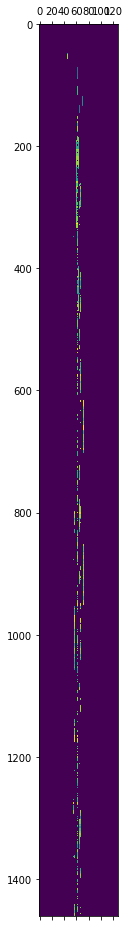

In [56]:
# Graficamos de vuelta el pianoroll
plt.matshow(decoded)

In [57]:
new_track = pypianoroll.Track(decoded)

In [58]:
new_multitrack = pypianoroll.Multitrack(tracks=[new_track])

In [59]:
new_multitrack.write('experiment.mid')

In [509]:
!vlc experiment.mid

VLC media player 3.0.11 Vetinari (revision 3.0.11-0-gdc0c5ced72)
[00005611a6052b10] main libvlc: Running vlc with the default interface. Use 'cvlc' to use vlc without interface.
Qt: Session management error: None of the authentication protocols specified are supported
[00007f6238001150] smf demux: Track name: unknown
fluidsynth: warning: Failed to pin the sample data to RAM; swapping is possible.
[00007f6238001150] smf demux: Track name: unknown
fluidsynth: warning: No preset found on channel 0 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 1 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 2 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 3 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 4 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 5 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 6 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 7 [bank=0 prog=0]
fluidsynth: warning: N